In [48]:
%cd /content/drive/MyDrive/ColabWork/PoseEstimation/UsingOpenCV

/content/drive/MyDrive/ColabWork/PoseEstimation/UsingOpenCV


In [80]:
!git init

Initialized empty Git repository in /content/drive/My Drive/ColabWork/PoseEstimation/UsingOpenCV/.git/


In [81]:

!git status

On branch master

No commits yet

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	.gitignore.gdoc
	AgStpsTechnqsApplied.ipynb
	Copy of multi-person-openpose.ipynb
	Football_train_1.mp4
	OpenPose_Notebook.ipynb
	TestData/
	Untitled0.ipynb
	pose_iter_160000.caffemodel
	pose_iter_440000.caffemodel

nothing added to commit but untracked files present (use "git add" to track)


# Now loading the caffe model, using .prototxt file

In [49]:
import numpy as np
import time
import matplotlib.pyplot as plt

In [50]:
import cv2
# Specify the paths for the 2 files
protoFile = "/content/drive/MyDrive/ColabWork/ToLearnFrom/learnopencv/OpenPose/pose/coco/pose_deploy_linevec.prototxt"
weightsFile = "pose_iter_440000.caffemodel"
# Read the network into Memory
net = cv2.dnn.readNetFromCaffe(protoFile,weightsFile)


# Checking on the single image

(1, 57, 46, 46)


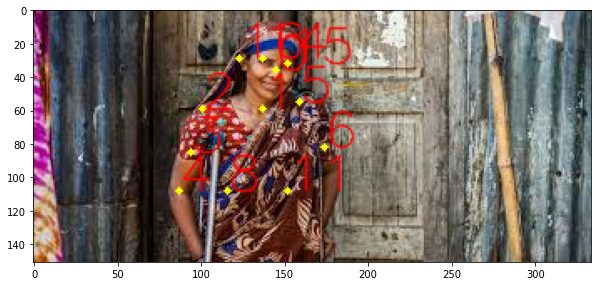

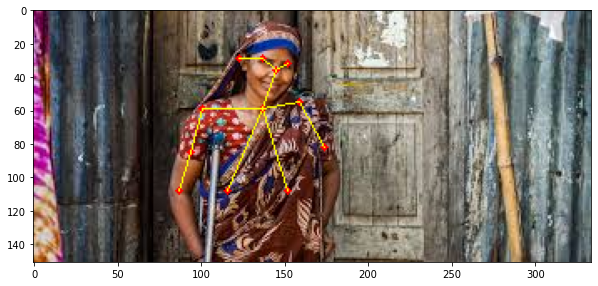

In [18]:
frame = cv2.imread("/content/drive/MyDrive/ColabWork/PoseEstimation/UsingOpenCV/TestData/single-person.jpg")
image1=frame
# Specify the input image dimensions
inWidth = 368
inHeight = 368
# Prepare the frame to be fed to the network
inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight), (0, 0, 0), swapRB=False, crop=False)
# Set the prepared object as the input blob of the network
net.setInput(inpBlob)
output=net.forward()
print(output.shape)
H = output.shape[2]
W = output.shape[3]
POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

# Empty list to store the detected keypoints
nPoints=18
frameWidth = image1.shape[1]
frameHeight = image1.shape[0]
threshold = 0.1
frameCopy = np.copy(frame)


points = []

for i in range(nPoints):
    # confidence map of corresponding body's part.
    probMap = output[0, i, :, :]

    # Find global maxima of the probMap.
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    
    # Scale the point to fit on the original image
    x = (frameWidth * point[0])/W
    y = (frameHeight * point[1])/H

    if prob > threshold : 
        cv2.circle(frameCopy, (int(x), int(y)), 2, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1, lineType=cv2.LINE_AA)
        cv2.circle(frame, (int(x), int(y)), 2, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

        # Add the point to the list if the probability is greater than the threshold
        points.append((int(x), int(y)))
    else :
        points.append(None)

# Draw Skeleton
for pair in POSE_PAIRS:
    partA = pair[0]
    partB = pair[1]

    if points[partA] and points[partB]:
        cv2.line(frame, points[partA], points[partB], (0, 255, 255), 1)

plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frameCopy, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Now we are going to go for Multi-Person, and for that we have to take care that points of different bodies are differentiated.

In [51]:
# Find the Keypoints using Non Maximum Suppression on the Confidence Map
# index of pafs correspoding to the POSE_PAIRS
# e.g for POSE_PAIR(1,2), the PAFs are located at indices (31,32) of output, Similarly, (1,5) -> (39,40) and so on.
# COCO Output Format
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16] ]

# index of pafs correspoding to the POSE_PAIRS
# e.g for POSE_PAIR(1,2), the PAFs are located at indices (31,32) of output, Similarly, (1,5) -> (39,40) and so on.
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], 
          [19,20], [21,22], [23,24], [25,26], [27,28], [29,30], 
          [47,48], [49,50], [53,54], [51,52], [55,56], 
          [37,38], [45,46]]

colors = [ [0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
         [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
         [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0]]


def getKeypoints(probMap, threshold=0.1):
    
    mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)

    mapMask = np.uint8(mapSmooth>threshold)
    keypoints = []
    
    #find the blobs
    contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #for each blob find the maxima
    for cnt in contours:
        blobMask = np.zeros(mapMask.shape)
        blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
        maskedProbMap = mapSmooth * blobMask
        _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
        keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

    return keypoints


In [65]:
# Find valid connections between the different joints of a all persons present
def getValidPairs(output):
    valid_pairs = []
    invalid_pairs = []
    n_interp_samples = 10
    paf_score_th = 0.3
    conf_th = 0.7
    # loop for every POSE_PAIR
    for k in range(len(mapIdx)):
        # A->B constitute a limb
        pafA = output[0, mapIdx[k][0], :, :]
        pafB = output[0, mapIdx[k][1], :, :]
        pafA = cv2.resize(pafA, (frameWidth, frameHeight))
        pafB = cv2.resize(pafB, (frameWidth, frameHeight))

        # Find the keypoints for the first and second limb
        candA = detected_keypoints[POSE_PAIRS[k][0]]
        candB = detected_keypoints[POSE_PAIRS[k][1]]
        nA = len(candA)
        nB = len(candB)

        # If keypoints for the joint-pair is detected
        # check every joint in candA with every joint in candB 
        # Calculate the distance vector between the two joints
        # Find the PAF values at a set of interpolated points between the joints
        # Use the above formula to compute a score to mark the connection valid
        
        if( nA != 0 and nB != 0):
            valid_pair = np.zeros((0,3))
            for i in range(nA):
                max_j=-1
                maxScore = -1
                found = 0
                for j in range(nB):
                    # Find d_ij
                    d_ij = np.subtract(candB[j][:2], candA[i][:2])
                    norm = np.linalg.norm(d_ij)
                    if norm:
                        d_ij = d_ij / norm
                    else:
                        continue
                    # Find p(u)
                    interp_coord = list(zip(np.linspace(candA[i][0], candB[j][0], num=n_interp_samples),
                                            np.linspace(candA[i][1], candB[j][1], num=n_interp_samples)))
                    # Find L(p(u))
                    paf_interp = []
                    for k in range(len(interp_coord)):
                        paf_interp.append([pafA[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))],
                                           pafB[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))] ]) 
                    # Find E
                    paf_scores = np.dot(paf_interp, d_ij)
                    avg_paf_score = sum(paf_scores)/len(paf_scores)
                    
                    # Check if the connection is valid
                    # If the fraction of interpolated vectors aligned with PAF is higher then threshold -> Valid Pair  
                    if ( len(np.where(paf_scores > paf_score_th)[0]) / n_interp_samples ) > conf_th :
                        if avg_paf_score > maxScore:
                            max_j = j
                            maxScore = avg_paf_score
                            found = 1
                # Append the connection to the list
                if found:            
                    valid_pair = np.append(valid_pair, [[candA[i][3], candB[max_j][3], maxScore]], axis=0)

            # Append the detected connections to the global list
            valid_pairs.append(valid_pair)
        else: # If no keypoints are detected
            print("No Connection : k = {}".format(k))
            invalid_pairs.append(k)
            valid_pairs.append([])
    print(valid_pairs)
    return valid_pairs, invalid_pairs


In [66]:
# This function creates a list of keypoints belonging to each person
# For each detected valid pair, it assigns the joint(s) to a person
# It finds the person and index at which the joint should be added. This can be done since we have an id for each joint
def getPersonwiseKeypoints(valid_pairs, invalid_pairs):
    # the last number in each row is the overall score 
    personwiseKeypoints = -1 * np.ones((0, 19))

    for k in range(len(mapIdx)):
        if k not in invalid_pairs:
            partAs = valid_pairs[k][:,0]
            partBs = valid_pairs[k][:,1]
            indexA, indexB = np.array(POSE_PAIRS[k])

            for i in range(len(valid_pairs[k])): 
                found = 0
                person_idx = -1
                for j in range(len(personwiseKeypoints)):
                    if personwiseKeypoints[j][indexA] == partAs[i]:
                        person_idx = j
                        found = 1
                        break

                if found:
                    personwiseKeypoints[person_idx][indexB] = partBs[i]
                    personwiseKeypoints[person_idx][-1] += keypoints_list[partBs[i].astype(int), 2] + valid_pairs[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < 17:
                    row = -1 * np.ones(19)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    # add the keypoint_scores for the two keypoints and the paf_score 
                    row[-1] = sum(keypoints_list[valid_pairs[k][i,:2].astype(int), 2]) + valid_pairs[k][i][2]
                    personwiseKeypoints = np.vstack([personwiseKeypoints, row])
    return personwiseKeypoints

In [54]:
image1 = cv2.imread("TestData/download.jpg")
frameWidth = image1.shape[1]
frameHeight = image1.shape[0]

In [72]:
t = time.time()
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)
'''
if device == "cpu":
    net.setPreferableBackend(cv2.dnn.DNN_TARGET_CPU)
    print("Using CPU device")
elif device == "gpu":
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
    print("Using GPU device")
'''
# Fix the input Height and get the width according to the Aspect Ratio
inHeight = 368
inWidth = int((inHeight/frameHeight)*frameWidth)

inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)
output = net.forward()
print("Time Taken = {}".format(time.time() - t))

Time Taken = 15.747673511505127


(-0.5, 299.5, 167.5, -0.5)

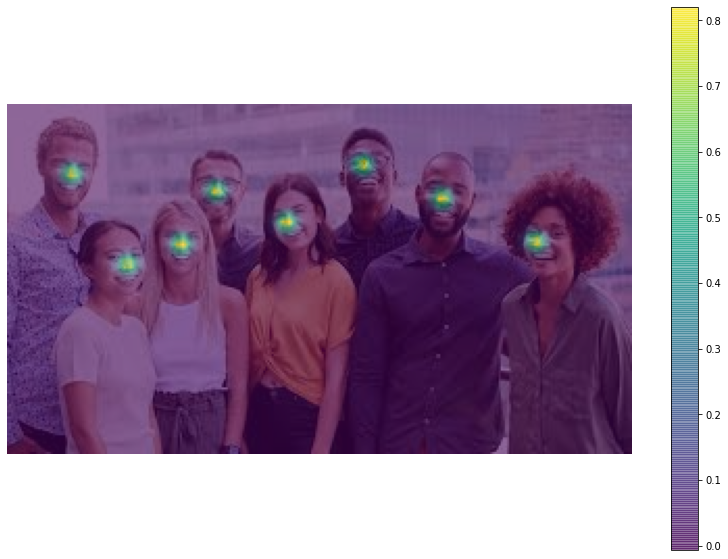

In [75]:
i = 0
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (frameWidth, frameHeight))
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off")

In [76]:
# COCO Output Format
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']
detected_keypoints = []
keypoints_list = np.zeros((0,3))
keypoint_id = 0
threshold = 0.4

for part in range(nPoints):
    probMap = output[0,part,:,:]
    probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
#     plt.figure()
#     plt.imshow(255*np.uint8(probMap>threshold))
    keypoints = getKeypoints(probMap, threshold)
    print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
    keypoints_with_id = []
    for i in range(len(keypoints)):
        keypoints_with_id.append(keypoints[i] + (keypoint_id,))
        keypoints_list = np.vstack([keypoints_list, keypoints[i]])
        keypoint_id += 1

    detected_keypoints.append(keypoints_with_id)


Keypoints - Nose : [(58, 77, 0.6440809), (84, 67, 0.81994444), (254, 66, 0.74175334), (134, 56, 0.78803474), (208, 45, 0.7988649), (99, 41, 0.7603614), (30, 33, 0.7095939), (171, 28, 0.7435078)]
Keypoints - Neck : [(48, 107, 0.65285534), (262, 97, 0.63524234), (84, 93, 0.6911557), (138, 82, 0.7128193), (207, 79, 0.640401), (175, 65, 0.5043278), (23, 63, 0.49195704)]
Keypoints - R-Sho : [(34, 107, 0.57750887), (240, 95, 0.58792186), (63, 95, 0.49114227), (118, 82, 0.6666386), (178, 81, 0.57270473)]
Keypoints - R-Elb : [(34, 151, 0.63317597), (171, 127, 0.43529242)]
Keypoints - R-Wr : []
Keypoints - L-Sho : [(60, 106, 0.54248846), (283, 100, 0.5403158), (106, 93, 0.6582857), (157, 83, 0.6065559), (236, 78, 0.52617896), (45, 63, 0.42757085)]
Keypoints - L-Elb : [(109, 133, 0.5742401), (157, 118, 0.56839514)]
Keypoints - L-Wr : [(106, 162, 0.61906487)]
Keypoints - R-Hip : []
Keypoints - R-Knee : []
Keypoints - R-Ank : []
Keypoints - L-Hip : []
Keypoints - L-Knee : []
Keypoints - L-Ank : []

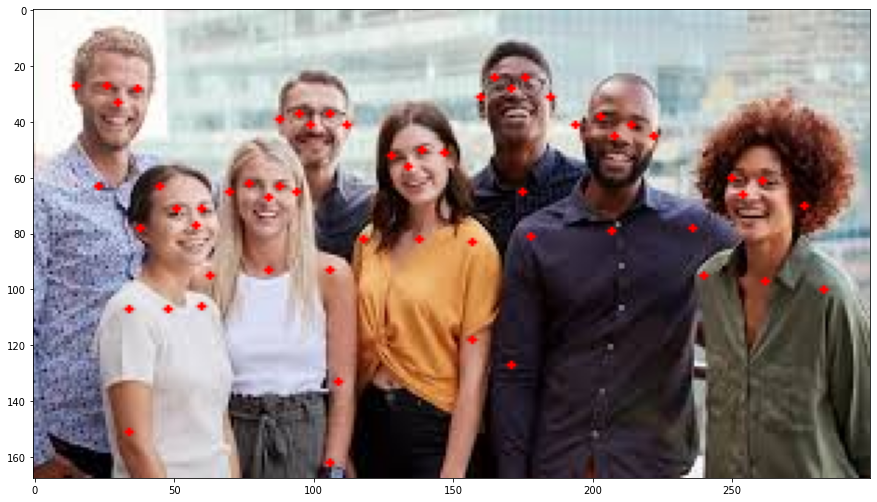

In [77]:
frameClone = image1.copy()
for i in range(nPoints):
    for j in range(len(detected_keypoints[i])):
        cv2.circle(frameClone, detected_keypoints[i][j][0:2], 1, [0,0,255], -1, cv2.LINE_AA)
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])

In [78]:
valid_pairs, invalid_pairs = getValidPairs(output)

No Connection : k = 3
No Connection : k = 6
No Connection : k = 7
No Connection : k = 8
No Connection : k = 9
No Connection : k = 10
No Connection : k = 11
[array([[ 8.        , 15.        ,  0.81586291],
       [ 9.        , 16.        ,  0.75502463],
       [10.        , 17.        ,  0.63682335],
       [11.        , 18.        ,  0.8210297 ],
       [12.        , 19.        ,  0.72467614]]), array([[ 8.        , 22.        ,  0.80852837],
       [ 9.        , 23.        ,  0.71455446],
       [10.        , 24.        ,  0.68512985],
       [11.        , 25.        ,  0.74151718],
       [12.        , 26.        ,  0.70591191],
       [14.        , 27.        ,  0.62703992]]), array([[15.        , 20.        ,  0.79375955],
       [19.        , 21.        ,  0.65408215]]), [], array([[24.        , 28.        ,  0.73494363],
       [25.        , 29.        ,  0.83622455]]), array([[28.        , 30.        ,  0.64830215]]), [], [], [], [], [], [], array([[ 8.        ,  0.        ,  0.

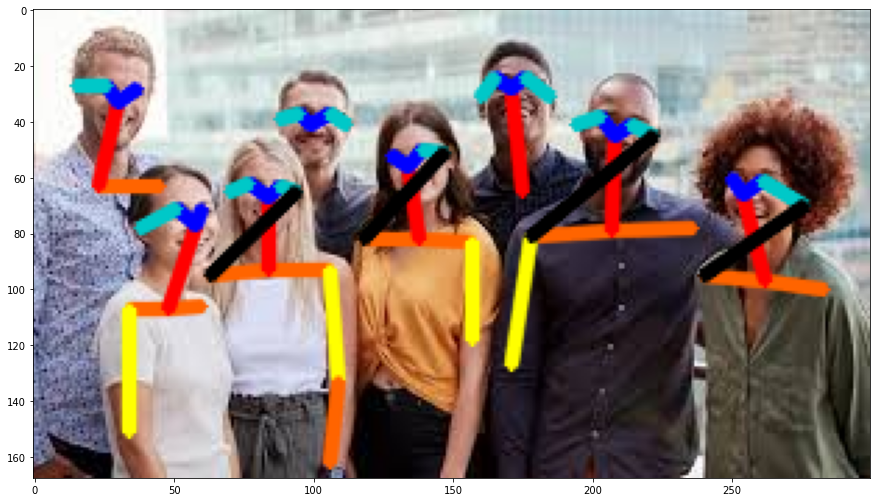

In [79]:
personwiseKeypoints = getPersonwiseKeypoints(valid_pairs, invalid_pairs)

for i in range(nPoints):
    for n in range(len(personwiseKeypoints)):
        index = personwiseKeypoints[n][np.array(POSE_PAIRS[i])]
        if -1 in index:
            continue
        B = np.int32(keypoints_list[index.astype(int), 0])
        A = np.int32(keypoints_list[index.astype(int), 1])
        cv2.line(frameClone, (B[0], A[0]), (B[1], A[1]), colors[i], 3, cv2.LINE_AA)
        
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])